# Attempts at minimalistic flow modeling

Links:
* Solving for pressure (making fluid incompressible): https://www.karlsims.com/fluid-flow.html
* Moving the fluid (See subtitle "Stam's Advection"): https://www.gamasutra.com/view/feature/1549/practical_fluid_dynamics_part_1.php?print=1
* https://www.researchgate.net/publication/27293557_Interacting_with_smoke_and_Fire_in_real_time

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

In [2]:
def shift(a, axis=0):
    """Utility function: shift all rows or cols in a matrix by 1, padding with 0s"""
    if axis==0:
        n = a.shape[1]
        return np.concatenate((np.zeros((1,n)), a[:-1,:]), axis=0)
    if axis==1:
        n = a.shape[0]
        return np.concatenate((np.zeros((n,1)), a[:,:-1]), axis=1)
    
print(shift(np.array([[1,2,3], [4,5,6]]), axis=0))
print(shift(np.array([[1,2,3], [4,5,6]]), axis=1))

[[0. 0. 0.]
 [1. 2. 3.]]
[[0. 1. 2.]
 [0. 4. 5.]]


In [42]:
# Test 2d convolutions
a = np.zeros((6,6))
a[1,2] = 1
a[3,5] = 1
b = np.array([[0,1,0], [1,2,3], [0,-1,0]])

print(a)
print(b)
print(sig.convolve2d(a, b, mode='same'))

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[ 0  1  0]
 [ 1  2  3]
 [ 0 -1  0]]
[[ 0.  0.  1.  0.  0.  0.]
 [ 0.  1.  2.  3.  0.  0.]
 [ 0.  0. -1.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  2.]
 [ 0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.]]


The formulas for divergence removal are given, and almost derived, here: https://www.karlsims.com/fluid-flow.html

Citation: Fluid Flow Tutorial, Karl Sims. 2018.

Based on: Jos Stam, "Stable Fluids", SIGGRAPH 1999 Conference Proceedings

But briefly, we have a vector field, so the divergence of it is a scalar field. But to make it flat, we can repeatedly remove the gradient from it. Mathematically, gradient points towards fastest increase of a scalar field (so it points where divergence is high), but divergence is high if flows are leading away from this point (so the "pressure" there is low) Which means that to flatten the pressure, we should *add* the gradient of divergence to our vector field. This would create extra flows from regions of high pressure and towards regions of low pressure.

Now, another trick to make these calculations easier is to calculate divergence at corners of pixels, not at the center of pixels. Here's the logic: if you are calculating a derivative, it's easier to calculate it at the borders of segments (where it becomes a simple Δ of adjacent values). Same for divergence (which is one type of a derivative in space); it's easier to calculate it between pixels (at corners), looking at 4 pixels neighboring each corner. But then as we calculate the gradient, it's again easier to calculate it between the points where derivative was defined. So because we have 2 derivative-like operations in a row, we shift our coordinate system twice, from centers to corners, and then back again to centers. If you really write it all down, you indeed get the formulas described at the site.

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[-0.029 -0.052 -0.046 -0.052 -0.029]
 [ 0.052 -0.04  -0.184 -0.04   0.052]
 [-0.046  0.184  0.46   0.184 -0.046]
 [ 0.052 -0.04  -0.184 -0.04   0.052]
 [-0.029 -0.052 -0.046 -0.052 -0.029]]
[[ 0.029 -0.006 -0.     0.006 -0.029]
 [ 0.006  0.132 -0.    -0.132 -0.006]
 [-0.     0.     0.    -0.    -0.   ]
 [-0.006 -0.132 -0.     0.132  0.006]
 [-0.029  0.006 -0.    -0.006  0.029]]


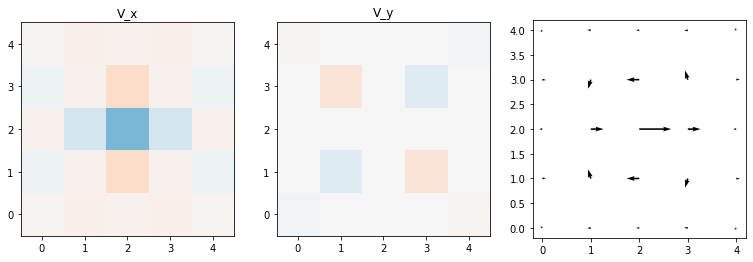

In [240]:
# Divergence, aka pressure relaation
def remove_divergence(vx, vy, alpha=0.1):
    """Make one step towards cancelling divergence. The formulas come from here:
    https://www.karlsims.com/fluid-flow.html
    alpha is the learning rate."""

    # Convolution filters:
    xx = np.array([[ 1,-2, 1],
                   [ 2,-4, 2],
                   [ 1,-2, 1]])/8
    xy = np.array([[ 1, 0,-1],
                   [ 0, 0, 0],
                   [-1, 0, 1]])/8 # yx is the same as xy.
    # Compared to karlsims this matrix is flipped, as matrices are indexed top-down
    yy = np.array([[ 1, 2, 1],
                   [-2,-4,-2],
                   [ 1, 2, 1]])/8
    ox = vx + (sig.convolve2d(vx, xx, mode='same') + 
               sig.convolve2d(vy, xy, mode='same'))*alpha
    oy = vy + (sig.convolve2d(vy, yy, mode='same') + 
               sig.convolve2d(vx, xy, mode='same'))*alpha
    return (ox,oy)

# Test: start with all zeros, except for one cell in the very middle
vx = np.zeros((5,5))
vx[2,2] = 1
vy = np.zeros((5,5))
print(vx)
(vx,vy) = remove_divergence(vx,vy)
for i in range(1000):
    (vx,vy) = remove_divergence(vx,vy)
plt.figure(figsize=(13,4))
plt.subplot(131); plt.title('V_x');
plt.imshow(vx, cmap='RdBu', clim=(-1,1), origin='lower');
plt.subplot(132); plt.title('V_y');
plt.imshow(vy, cmap='RdBu', clim=(-1,1), origin='lower');
plt.subplot(133);
plt.quiver(*np.meshgrid(range(5), range(5)), vx, vy, units='x', scale=0.7);
with np.printoptions(precision=3, suppress=True):
    print(vx)
    print(vy)

[[-0.  0. -0.  0.]
 [-0. -0.  0.  0.]
 [-0. -0.  0.  0.]
 [-0.  0. -0.  0.]]


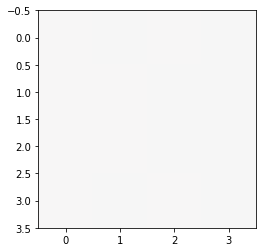

In [146]:
# Ultimate test: calculate divergence explicitly
def div(vx, vy):
    mask = np.array([[-1,1],[-1,1]])    
    return sig.convolve2d(vx, mask, mode='valid')+sig.convolve2d(vy, mask.T, mode='valid')

d = div(vx, vy)
plt.imshow(d, cmap='RdBu', clim=(-1,1));
with np.printoptions(precision=3, suppress=True):
    print(d)

Sum before: 1.0
[[0.    0.    0.    0.    0.   ]
 [0.    0.062 0.062 0.062 0.   ]
 [0.    0.062 0.5   0.062 0.   ]
 [0.    0.062 0.062 0.062 0.   ]
 [0.    0.    0.    0.    0.   ]]
Sum after: 1.0


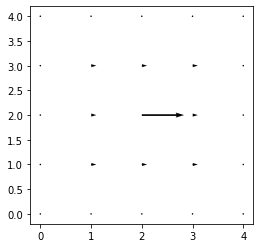

In [268]:
# Viscosity
def viscosity(vx, vy, beta=0.01):
    """Just a blurring mask, essentially"""
    #viskmask = [[1,2,1],[2,-12,2],[1,2,1]]
    viskmask = np.array([[1,1,1],[1,-8,1],[1,1,1]])/8
    return (vx + beta*sig.convolve2d(vx, viskmask, mode='same'),
            vy + beta*sig.convolve2d(vy, viskmask, mode='same'))

vx = np.zeros((5,5))
vx[2,2] = 1
vy = np.zeros((5,5))
print('Sum before:',np.sum(vx)) # If velocity works right, it should mostly smoothen movement, not change the amount of it
                                # (although at some point immovable edges will start to still everything)
vx,vy = viscosity(vx, vy, beta=0.5)
plt.figure(figsize=(4,4))
plt.quiver(*np.meshgrid(range(5), range(5)), vx, vy, units='x', scale=0.6);
with np.printoptions(precision=3, suppress=True):
    print(vx)
print('Sum after:', np.sum(vx))

**Stam's Advection** is described here: https://www.gamasutra.com/view/feature/1549/practical_fluid_dynamics_part_1.php?print=1

Citation: West, M. (2008). Practical fluid dynamics: Part 1. Game Developer magazine.

The idea is that if fluid is moving with speed $\bar v$, then this speed vector carries all properties of fluid, including momentum itself. Which means that if you "step back" (look back) at the point $-\bar v$ (using interpolation), then this will be a new speed at this pixel. It has a bunch of pboblems though (some mentioned in the paper). Another problem is that it expicitly zeroes all speeds normal to the boundary at boundary, as once we attempt to extrapolate beyond the boundary, we get a zero. *Or should we actually get something different, like a flat value or something? Maybe check what behavior looks more reasonable?*

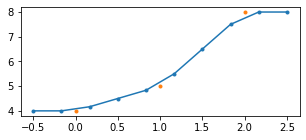

In [317]:
# Utility funciton: linear interpolation
def interp(mat, x, y):
    """Bilinearly interpolate within matrix f, using real x and y (like i,j, but fractional).
    x is essentially row, and y is essentially column, note the dimensions.
    Ref: https://en.wikipedia.org/wiki/Bilinear_interpolation """
    x = min(mat.shape[0]-1, max(0, x))  # To limit values at edges
    y = min(mat.shape[1]-1, max(0, y))
    i = np.floor(x).astype(int) # Whole part    
    j = np.floor(y).astype(int)    
    i = min(i, mat.shape[0]-2) # For the formula to work, we cannot be on the right border,
    j = min(j, mat.shape[1]-2) # as the fomula references "next" element, which is i+1    
    return (mat[i,j  ]*(i+1-x)*(j+1-y) + mat[i+1,j  ]*(x-i)*(j+1-y) + 
            mat[i,j+1]*(i+1-x)*(y-j  ) + mat[i+1,j+1]*(x-i)*(y-j))

# Test
mat = np.array([[1,2,7],[4,5,8]])
x = np.linspace(-0.5, 2.5, 10)
plt.figure(figsize=(5,2))
plt.plot(x, [interp(mat, 1, i) for i in x],'.-');
plt.plot(range(0,3), mat[1,:], '.');

Below we actually have to make a decision of how the image in our head is represented in the matrix. When I think of the image, I wand the first index of a matrix correpond to X coordinate, and the 2nd index - to Y coordinate. But in matrices, obviously, the first is a row counted from the top, and 2nd is the column. So I have three options:
* Either i is -y, and j is x (then print(a) and img(a) look the same, but that's horrible)
* Or i is y, and j is x (then y is flipped, which means that the math is sane, but still its [y,x] notation)
* Or treat i as x, and j as y. In which case it is all flipped. But that's the approach I take here.

Field:
 [[1 1 1]
 [0 1 0]
 [1 0 0]]
[[1.   1.   1.  ]
 [0.   0.75 0.25]
 [1.   0.25 0.  ]]


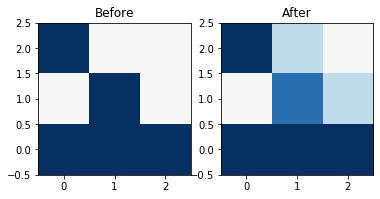

In [318]:
# Calculate advection
def advect(field, vx, vy):
    """Advect the field using vx and vy local fluid speeds."""
    val = np.zeros(field.shape)
    for i in range(field.shape[0]):
        for j in range(field.shape[1]):            
            val[i,j] = interp(field, i-vy[i,j], j-vx[i,j]) # i is Y, j is X
            #val[i,j] = field[np.round(i-vy[i,j]).astype(int), 
            #                 np.round(j-vx[i,j]).astype(int)] # i is Y, j is X
    return val

a = np.array([[1,1,1],[0,1,0],[1,0,0]])
vx = np.array([[0,1,1],[0,1,1],[0,1,1]])/4 # Right 2/3ds of the field are moving right
vy = np.zeros(vx.shape)
plt.subplot(121); plt.imshow(a, cmap='RdBu', clim=(-1,1), origin='lower'); plt.title('Before');
print('Field:\n',a)
a = advect(a, vx, vy)
with np.printoptions(precision=3, suppress=True):
    print(a)
plt.subplot(122); plt.imshow(a, cmap='RdBu', clim=(-1,1), origin='lower'); plt.title('After');

In [319]:
def prettyplot(plotn, plotm, plotk, data):
    """Create a subplot, then plot the data"""        
    ax = plt.subplot(plotn, plotm, plotk)
    plt.imshow(data, cmap='RdBu', origin='lower', clim=(-1,1))    
    plt.xticks([])
    plt.yticks([])

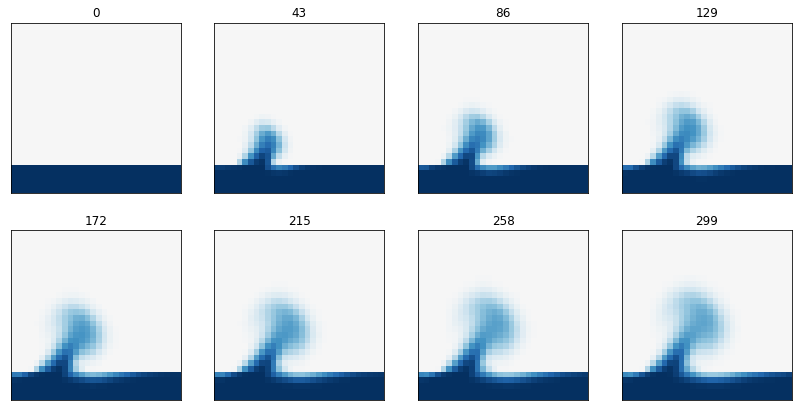

In [326]:
# Now bringing it all together

ngrid = 30          # Grid Dimensions
pcycles = 5         # How many pressure cycles to run on one advection cycle (50?)
alpha = 0.1         # Pressure relaxation rate (0.1?)
beta =  0.02        # Viscosity (0.01?)
ntime = 300         # How many time steps to run

vx = np.zeros((ngrid,ngrid)) # Speed components
vy = np.zeros((ngrid,ngrid))

vx[3:6,4:7] = 1.7   # Give the fluid a starting push somewhere in the middle
vy[3:6,4:7] = 2.2

field = np.zeros((ngrid,ngrid)) # Color fluid
#for i in range(ngrid):
#    for j in range(ngrid):
#        field[i,j] = ((i % 4)+1) // 4 # Stripes
field[0:5,:] = 1

(plotn, plotm) = (2,4)
plotcount = 1
nplots = plotn*plotm

timestep = np.ceil(ntime/(nplots-1))
fig = plt.figure(figsize=(14,7))
for t in range(ntime):    
    if (t % timestep == 0) or (t == ntime-1):
        prettyplot(plotn, plotm, plotcount, field)
        plt.title(t)
        plotcount += 1
    
    for q in range(pcycles):
        (vx, vy) = remove_divergence(vx, vy, alpha)
    (vx, vy) = viscosity(vx, vy, beta)        
    field = advect(field, vx, vy)
    (vx, vy) = (advect(vx, vx, vy), advect(vy, vx, vy))